# Showcasing pcrglobwb_utils

This notebook should provide a first impression on what the ``pcrglobwb_utils`` package and the functions therein can contribute to evaluating PCR-GLOBWB runs and output.

It contains:

* Extracting meta-data information from [GRDC-stations](#GRDC_info) (name, location);
* [Extracting timeseries](#get_data) from GRDC-file and netCDF-file at specified cell;
* [Validation](#validate) of simulated data with observations;
* [Resampling](#resampling) to different frequencies and using different statistical descriptors;
* Analyse [ensemble data](#ensembles)

## Preparation

### Load packages

In [1]:
%matplotlib inline

import pcrglobwb_utils
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import spotpy as sp
import os, sys
import datetime

Always handy to get some information on which system and with which version the notebook was run!

In [2]:
print('this notebook was created using Python', str((sys.version)), 'on a', str(sys.platform),'on', datetime.datetime.now())

this notebook was created using Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ] on a darwin on 2023-01-30 14:04:23.929484


In [3]:
pcrglobwb_utils.utils.print_versions()

pcrglobwb_utils version 0.3.4
pandas version 1.5.3
xarray version 2023.1.0
numpy version 1.23.5
geopandas version 0.12.2
rasterio version 1.3.4
rioxarray version 0.13.3


# Working with timeseries

<a id="GRDC_info"></a>

## Get information about GRDC-station and its location

A data source often used for validating simulated discharge is the Global Runoff Data Centre ([GRDC](https://portal.grdc.bafg.de/applications/public.html?publicuser=PublicUser#)). With the functions implemented in pcrglobwb_utils, it becomes much more straightforward to validate simulated discharge with observations. All is needed is the nc-file containing simulated discharge and the GRDC-file containing observed values.

By means of a GRDC-file containing daily discharge for the station Obidos in the Amazon River basin, the workflow is explained. First, we read the file which forms the basis for all subsequent steps.

In [4]:
##- create a python-object for the GRDC-data, here daily values
grdc_data = pcrglobwb_utils.obs_data.grdc_data('example_data/GRDC/files/3629000_Obidos.day')

As long as the file follows the 'default' GRDC-format, the tool parses the content to find the right entries. This is used to return some important meta-data about the station.

In [5]:
##- get a simple plot_title and properties (as dictionary) for this GRDC station
props = grdc_data.get_grdc_station_properties()

print(props)

{'grdc_no': 3629000, 'station': 'OBIDOS - PORTO', 'latitude': -1.9472, 'longitude': -55.5111, 'cat_area': 4680000.0, 'ts_start': Timestamp('1927-12-01 00:00:00'), 'ts_end': Timestamp('1998-05-01 00:00:00'), 'no_years': 72}


We now know where this specific location is located based on lat/lon information. This in turn can be employed to find the corresponding cell in the netCDF-file and extract a timeseries of simulated discharge from there.

In [6]:
pcr_data = pcrglobwb_utils.sim_data.from_nc('example_data/GRDC/DUMMY_discharge_dailyTot_output.nc')

In [7]:
##- based on lon/lat information of GRDC station, find corresponding row/col indices in nc-file
row, col = pcr_data.get_indices(props['longitude'], props['latitude'])

In [8]:
print('The location {} with its latitude {} and longitude {} corresponds to the cell with row and cell indeces {}'.format(props['station'], props['latitude'],props['longitude'],(row, col)))

The location OBIDOS - PORTO with its latitude -1.9472 and longitude -55.5111 corresponds to the cell with row and cell indeces (17, 50)


Fortunately, the river network and coordinates match! We are not ready to extract timeseries from both the GRDC and PCR-GLOBWB files!

<a id="get_data"></a>

## Reading values files and visualzing them

### From GRDC file

We already know the station name, where the GRDC-station is located, and that river network and coordinates match. Now let's get to the pudels kern and get the timeseries of observed discharge at this station.

Let's check the daily discharge data at Obidos. We can directly plot the timeseries and give it a user-specified variable name.

In [9]:
df_grdc, props = grdc_data.get_grdc_station_values(var_name='Q$obs$ GRDC [m3/s]', col_name=' Calculated')

In [10]:
props

{'grdc_no': 3629000,
 'station': 'OBIDOS - PORTO',
 'latitude': -1.9472,
 'longitude': -55.5111,
 'cat_area': 4680000.0,
 'ts_start': Timestamp('1927-12-01 00:00:00'),
 'ts_end': Timestamp('1998-05-01 00:00:00'),
 'no_years': 72}

Once we have retrieved the timeseries, the station properties are updated with the startdate and enddate of observations. Note, that this does not say anything about the number of missing values in this timeseries and when they occur!

In [11]:
print('Start data of the observations is {} and the end data is {}'.format(props['ts_start'], props['ts_end']))

Start data of the observations is 1927-12-01 00:00:00 and the end data is 1998-05-01 00:00:00


### From Excel file

Observed discharge is not always retrieved from the GRDC. If the file is not structured like GRDC files but a simple Excel-file with one (!) sheet containing two columns (date and value), we could do the same by reading from a non-GRDC formatted Excel-file. In this case, we do of course miss the station meta-data.

*Note: for this example the GRDC data was copied into an Excel-file, thus the absolute agreement between both timeseries.*

In [12]:
##- first, create a python-object 
excel_data = pcrglobwb_utils.obs_data.other_data('example_data/GRDC/Obidos_data.xlsx')

# second, apply method
df_excel = excel_data.get_values_from_excel(var_name='Q$obs$ Excel [m3/s]', remove_mv=True)

### From nc-file

Thus far, we looked merely at observed values. Time to check out the simulated values too! To that end, we first read the netCDF-file containing simulated discharge data. 

In [13]:
pcr_data = pcrglobwb_utils.sim_data.from_nc('example_data/GRDC/DUMMY_discharge_dailyTot_output.nc')

Above, we already determined the row and column indices of the GRDC-station we use for model validation. These indices now serve as input to retrieve the timeseries from the netCDF-file and store it as dataframe. Again, the user can specify a variable name.

In [14]:
# apply method to read values at specific row and col
q_sim_obidos = pcr_data.get_values(row, col, plot_var_name='Q$sim$ PCR-GLOBWB [m3/s]', plot=False)

Together with the above-retrieved dataframe containing the observed values, we can now finally compare the timeseries!

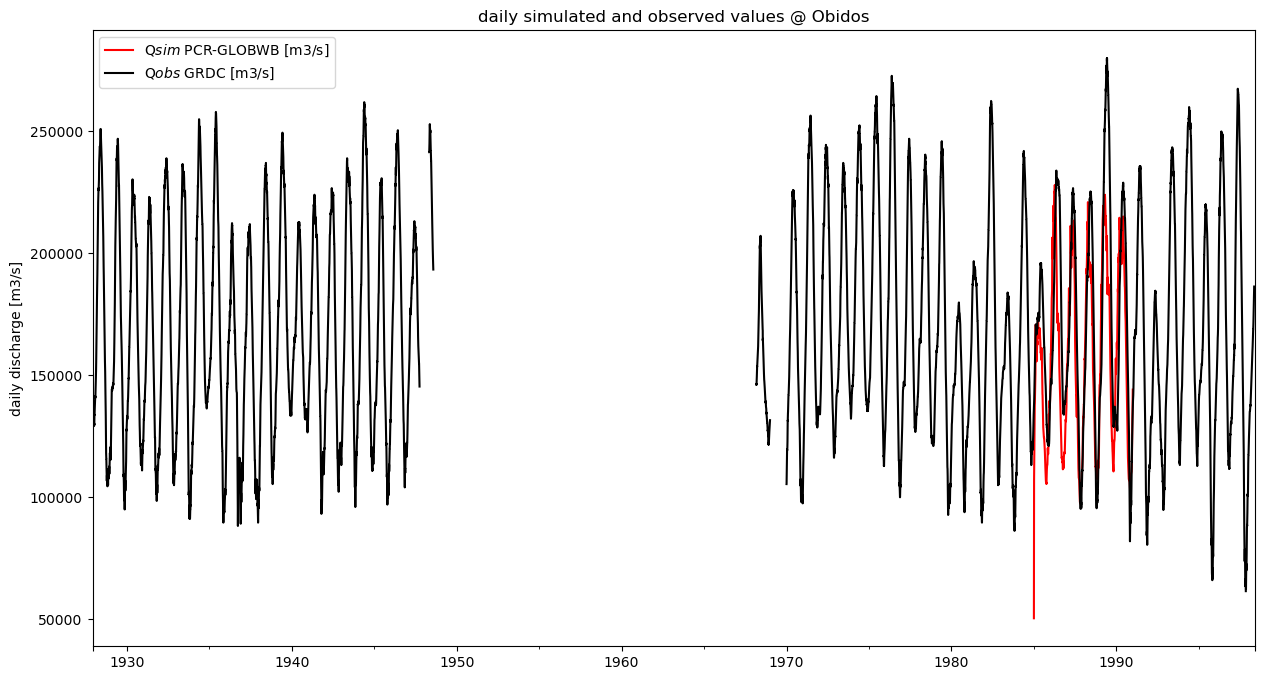

In [15]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(15,8))
q_sim_obidos.plot(ax=ax, c='r')
df_grdc.plot(ax=ax, c='k')
ax.set_ylabel('daily discharge [m3/s]')
ax.set_xlabel(None)
plt.legend()
plt.title('daily simulated and observed values @ Obidos');

<a id="validate"></a>

## Validation of daily values

Eventually, we do not only want to look at timeseries, but validate the accuracy of simulated discharge wiht observation. Currently, we can compute the KGE (with or without its components), NSE, RMSE, and R2 based on simulations and observations. To do so, both timeseries need to be clipped to the common period and missing values are removed.

In [16]:
df_eval = pcr_data.validate(df_grdc, station=props['station'], out_dir='./_OUT', return_all_KGE=False)

In [17]:
df_eval

,OBIDOS - PORTO
KGE,7.120000e-01
NSE,4.960000e-01
MSE,9.555419e+08
RMSE,3.091184e+04
RRMSE,7.100000e-01
R2,6.000000e-01


<a id="resampling"></a>

## Resampling over time using different statistical descriptors

### Averaging

It is also possible to resample timeseries from, for instance, daily values to monthly or even yearly values. Thereby, the resampling can be done using the monthly/yearly mean (default setting) or used to determine minimum and maximum mean value per month or year.

In [18]:
q_sim_obidos_monthly = pcr_data.to_monthly(stat_func='mean', suffix=' monthly mean')
q_sim_obidos_monthlyMAX = pcr_data.to_monthly(stat_func='max', suffix=' monthly max')
q_sim_obidos_monthlyMIN = pcr_data.to_monthly(stat_func='min', suffix=' monthly min')

INFO -- resampling data to monthly mean.
INFO -- resampling data to monthly max.
INFO -- resampling data to monthly min.


By using min, mean, and max monthly values, the boundaries of discharg can be plotted nicely.

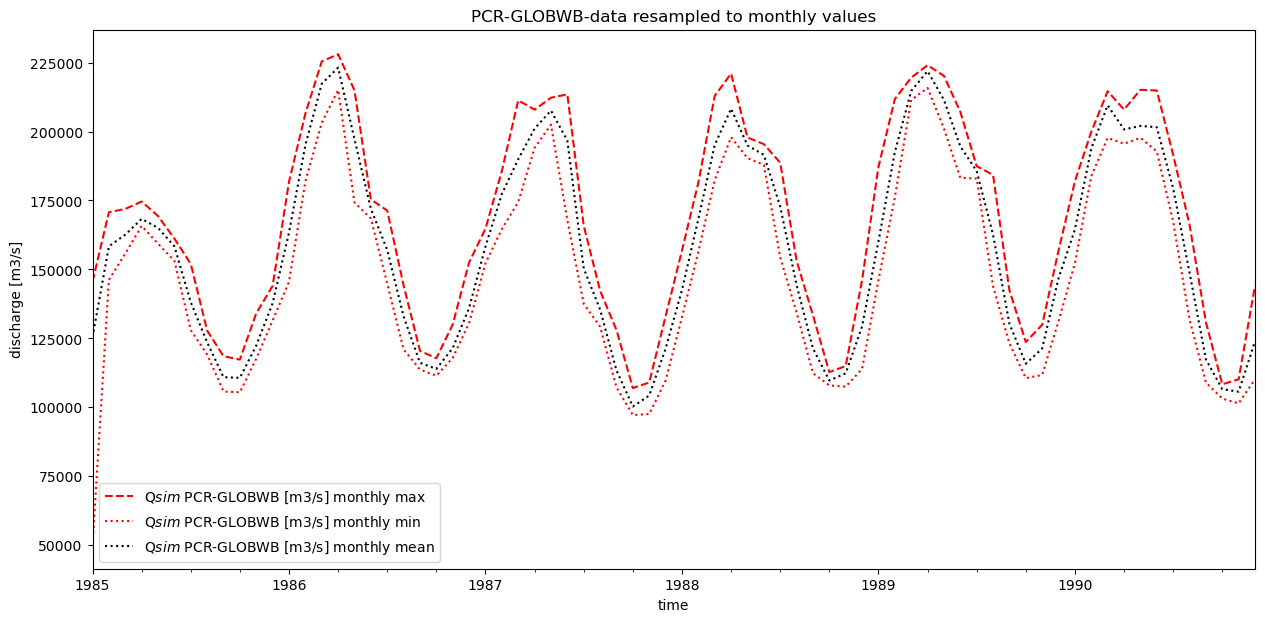

In [19]:
ax = q_sim_obidos_monthlyMAX.plot(c='r', linestyle='--', figsize=(15,7))
q_sim_obidos_monthlyMIN.plot(ax=ax, c='r', linestyle=':')
q_sim_obidos_monthly.plot(ax=ax, c='k', linestyle=':', title='PCR-GLOBWB-data resampled to monthly values')
ax.set_ylabel('discharge [m3/s]');

Similarly, we can do this for observed discharge.

In [20]:
GRDC_data_monthly = grdc_data.to_monthly(stat_func='mean', suffix=' monthly mean')

INFO -- resampling data to monthly mean.


With this, the monthly average discharge from both observations and simulation can be plotted.

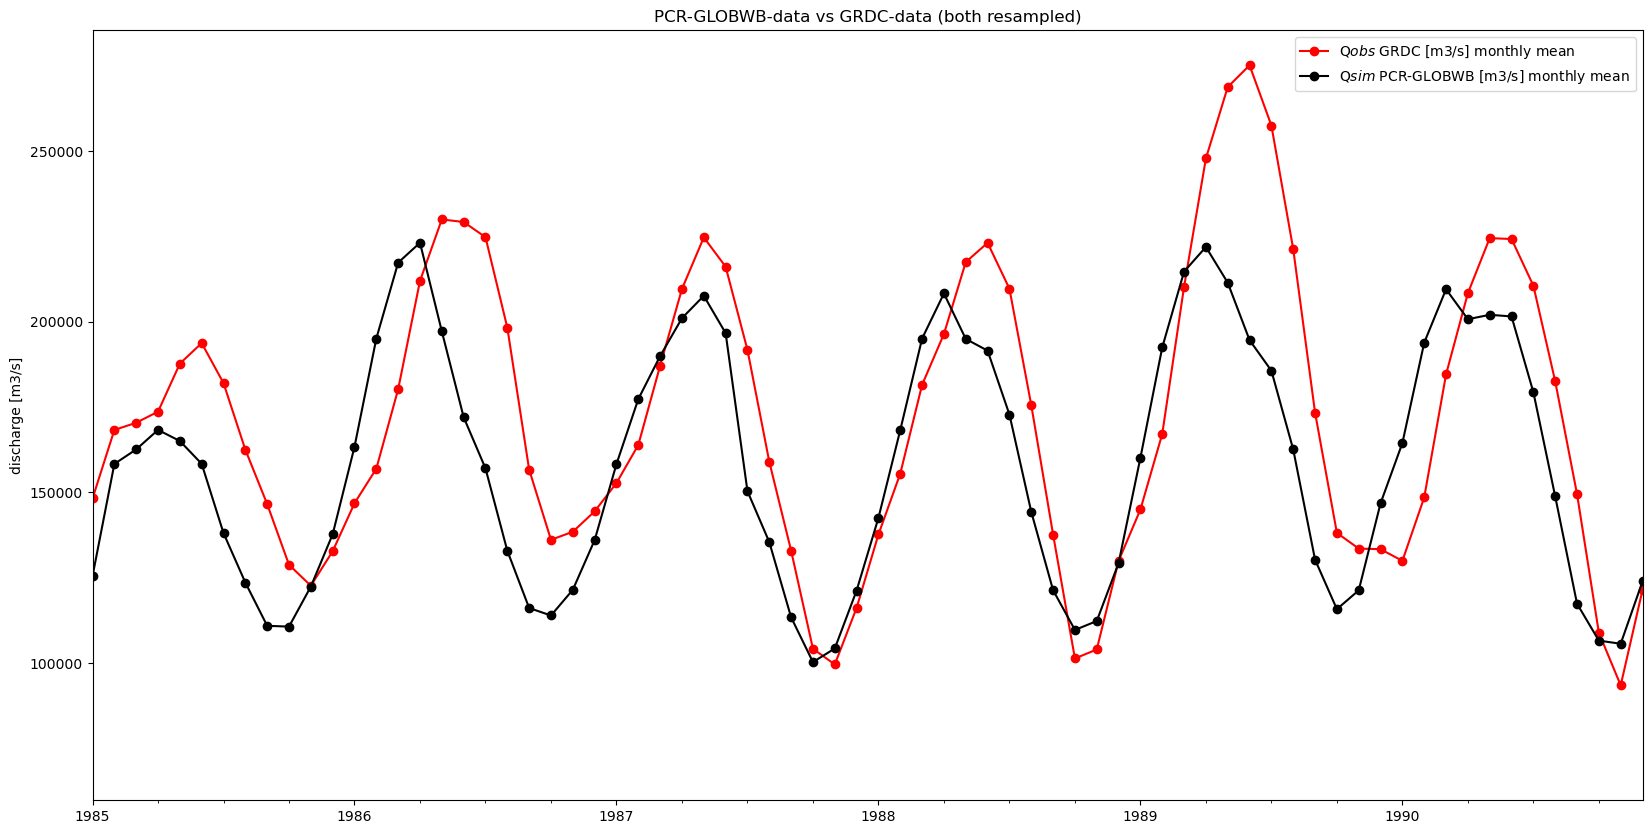

In [21]:
ax = GRDC_data_monthly.plot(c='r', marker='o', figsize=(20,10))
q_sim_obidos_monthly.plot(ax=ax, c='k', marker='o', title='PCR-GLOBWB-data vs GRDC-data (both resampled)')
ax.set_ylabel('discharge [m3/s]')
ax.set_xlabel(None)
ax.set_xlim(q_sim_obidos_monthly.index.values[0], q_sim_obidos_monthly.index.values[-1]);

<a id="ensembles"></a>

# Ensembles

If more than one run is performe, but an ensemble (e.g. with different RCPs), it can be useful to automatically compute and vizualize the mean, max, and min of the ensemble. So if we have timeseries of simulated discharge for one location based on an ensemble of simulations, they can easily be compared.

Since we only have output from one run here (the discharge data at Obidos as shown above), we compute a couple of dummy time series first by multiplying the actual data with random factors.

**Note that this functionality is hardly tested and therefore prone to errors!**

In [22]:
fact_arr = np.random.rand(9)

In [23]:
q_ens = [q_sim_obidos]
for factor, i in zip(fact_arr, range(len(fact_arr))):
    q_temp = q_sim_obidos.mul(factor)
    q_temp = q_temp.rename(columns={'Q$sim$ PCR-GLOBWB [m3/s]': i+1})
    q_ens.append(q_temp)

This list 'q_ens' represents now a ensemble runs which can be used as arguments for pcrglobwb_utils.

In [24]:
ens_obj = pcrglobwb_utils.ensembles.ensemble_data(q_ens[0], q_ens[1], q_ens[2], q_ens[4], q_ens[5], q_ens[9])

We can now calculate the mean, max, and min of the timeseries for each time step.

In [25]:
df_ens = ens_obj.calc_stats()
df_ens.head()

,Q$sim$ PCR-GLOBWB [m3/s],1,2,4,5,9,mean,max,min
time,,,,,,,,,
1985-01-01,50378.406250,22956.826172,21730.400391,26510.441406,30192.617188,46092.683594,32976.894531,50378.406250,21730.400391
1985-01-02,80150.671875,36523.683594,34572.476562,42177.390625,48035.632812,73332.203125,52465.343750,80150.671875,34572.476562
1985-01-03,95131.804688,43350.406250,41034.492188,50060.855469,57014.074219,87038.882812,62271.753906,95131.804688,41034.492188
1985-01-04,106136.960938,48365.320312,45781.492188,55852.058594,63609.648438,97107.828125,69475.554688,106136.960938,45781.492188
1985-01-05,107144.250000,48824.328125,46215.980469,56382.121094,64213.332031,98029.421875,70134.906250,107144.250000,46215.980469


It is also possible to determine the monthly mean climatology, i.e., the mean for each month based on the entire timeseries.

In [28]:
df_ens_clim = ens_obj.calc_climatology()

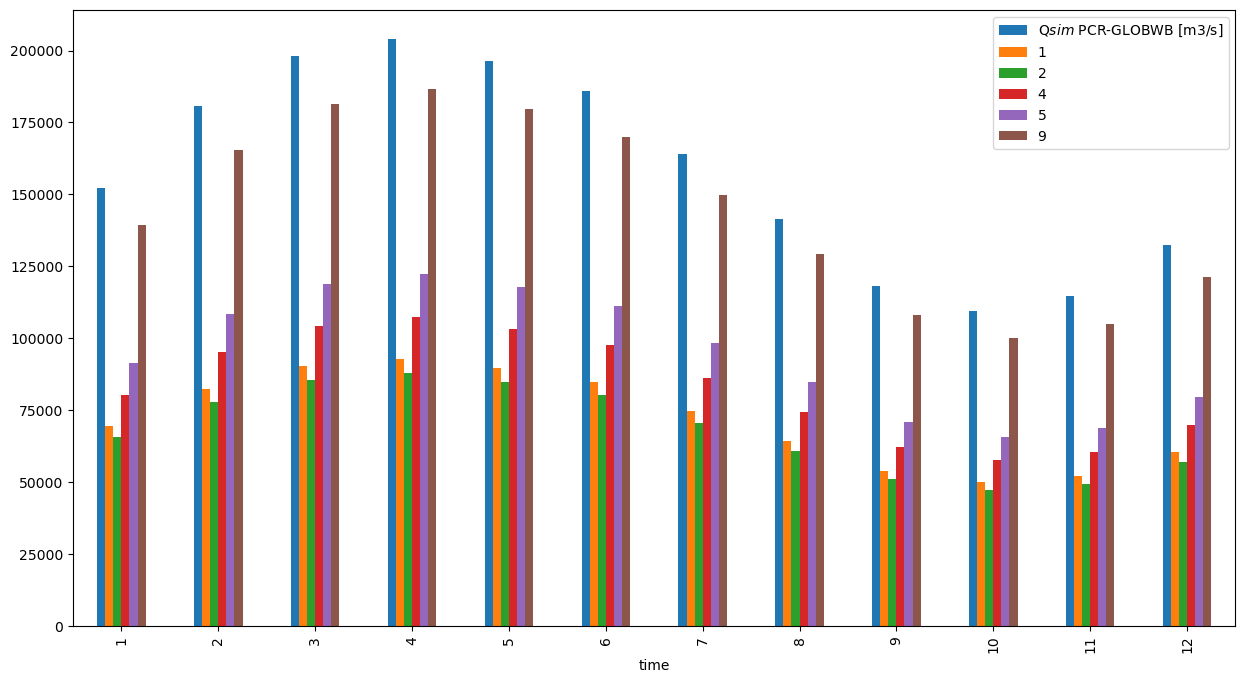

In [32]:
df_ens_clim.plot.bar(figsize=(15,8));